In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn

In [2]:
# load vector data.
data_df = pd.read_csv('Sort_seq_vector_fmt_input.csv',index_col=[0])

In [3]:
data_df.head()

,seq,bin,ct
0,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG,6,100
1,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG,8,89
2,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG,5,88
3,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG,7,84
4,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG,9,72


In [4]:
sequences = data_df['seq'].values
bin_counts = data_df['bin'].values
ct_n = data_df['ct'].values

In [5]:
NAR = mavenn.Model(regression_type='NA',
                   x=sequences, 
                   y=bin_counts, 
                   ct_n = ct_n,
                   gpmap_type='additive',
                   alphabet='dna',
                   theta_regularization=0.001,
                   ohe_batch_size=50000)

NAR.fit(epochs=30, 
        learning_rate=0.0005,
        early_stopping=True, 
        early_stopping_patience=5, 
        verbose=1)

Train on 36622 samples, validate on 9156 samples
Epoch 1/30
36622/36622 [==============================] - 1s 36us/step - loss: 110.9515 - val_loss: 104.1417
Epoch 2/30
36622/36622 [==============================] - 1s 30us/step - loss: 107.7577 - val_loss: 99.4937
Epoch 3/30
36622/36622 [==============================] - 1s 31us/step - loss: 102.1125 - val_loss: 96.5605
Epoch 4/30
36622/36622 [==============================] - 1s 31us/step - loss: 100.3345 - val_loss: 95.9816
Epoch 5/30
36622/36622 [==============================] - 1s 31us/step - loss: 99.9515 - val_loss: 95.7391
Epoch 6/30
36622/36622 [==============================] - 1s 29us/step - loss: 99.7487 - val_loss: 95.8318
Epoch 7/30
36622/36622 [==============================] - 1s 30us/step - loss: 99.6258 - val_loss: 95.5434
Epoch 8/30
36622/36622 [==============================] - 1s 30us/step - loss: 99.5061 - val_loss: 95.4894
Epoch 9/30
36622/36622 [==============================] - 1s 30us/step - loss: 99.4555 - v

In [6]:
loss_history = NAR.model.history

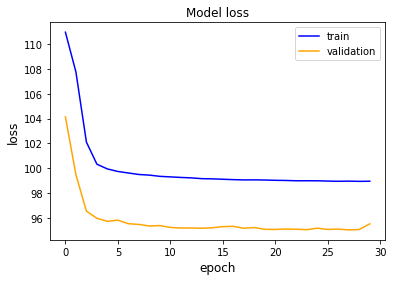

In [7]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

In [8]:
NAR.get_nn().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 166)          0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 156)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phiPrime (Dense)                (None, 1)            157         Sequence_only[0][0]              
__________________________________________________________________________________________________
fix_diffeomorphic_mode (fixDiff (None, 1)            0           phiPrime[0][0]                   
__________________________________________________________________________________________________
phi (Dense

In [9]:
NAR.get_nn()

In [10]:
phi = NAR.x_to_phi(sequences)

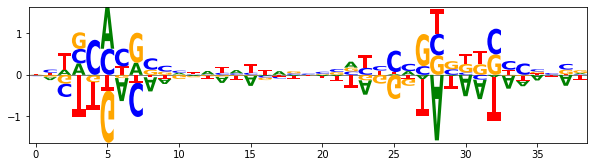

In [11]:
import logomaker
theta_df = pd.DataFrame(NAR.get_nn().layers[2].get_weights()[0].reshape(39,4),columns=['A','C','G','T'])
logomaker.Logo(theta_df,center_values=False)

In [12]:
phi_range = np.linspace(min(phi),max(phi),500)

In [13]:
p_of_all_y_given_phi = NAR.na_p_of_all_y_given_phi(phi_range)

[Text(0.5, 0, '-3.20'), Text(20.5, 0, '2.'), Text(40.5, 0, '8.168')]

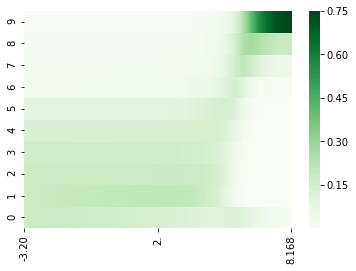

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
if p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][0]>p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][p_of_all_y_given_phi.T.shape[1]-1]:
    ax = sns.heatmap(pd.DataFrame(p_of_all_y_given_phi.T).loc[::1,::-1],cmap='Greens')
else:
    ax = sns.heatmap(p_of_all_y_given_phi.T,cmap='Greens')    
ax.invert_yaxis()
ax.set_xticks(([0,int(len(phi_range)/2),len(phi_range)-2]), minor=False)
middle_tick = str(phi_range[int(len(phi_range)/2)])
ax.set_xticklabels(([str(phi_range[0])[0:5],middle_tick[0:2],str(phi_range[len(phi_range)-1])[0:5]]), minor=False)